In [0]:
test_data_raw = spark.read.parquet("dbfs:/FileStore/tables/preprocessed_data.parquet")


In [0]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="label_column_name", outputCol="label")
test_data = indexer.fit(test_data_raw).transform(test_data_raw)


In [0]:
from pyspark.ml.classification import LogisticRegressionModel

lr_model = LogisticRegressionModel.load("dbfs:/tmp/logistic_model")


In [0]:
predictions = lr_model.transform(test_data)


In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType
import pandas as pd

# Convert probability vector to array for compatibility
vec_to_array = udf(lambda v: v.toArray().tolist(), ArrayType(DoubleType()))
predictions_fixed = predictions.withColumn("probability_array", vec_to_array("probability"))

# Now safely convert to Pandas
preds_pd = predictions_fixed.select("label", "prediction", "probability_array").toPandas()

preds_pd.head()


,label,prediction,probability_array
0,0.0,0.0,"[0.543355796089038, 0.45664420391096205]"
1,0.0,0.0,"[0.935082601412025, 0.06491739858797496]"
2,1.0,0.0,"[0.7345980185601563, 0.2654019814398437]"
3,0.0,0.0,"[0.9427405241369741, 0.05725947586302593]"
4,1.0,1.0,"[0.33092113174103804, 0.6690788682589619]"


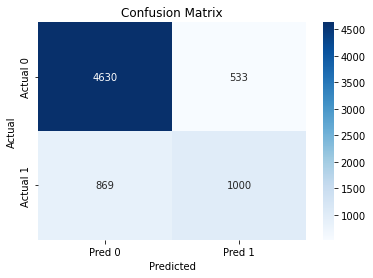

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Actual labels and predicted values
y_true = preds_pd["label"]
y_pred = preds_pd["prediction"]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Pred 0", "Pred 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

# Extract probability of class 1
extract_prob = udf(lambda v: float(v[1]), FloatType())
predictions_with_prob = predictions.withColumn("prob_class1", extract_prob("probability"))


In [0]:
pandas_df = predictions_with_prob.select("label", "prob_class1").toPandas()


Out[17]: <matplotlib.legend.Legend at 0x7880012f6b20>

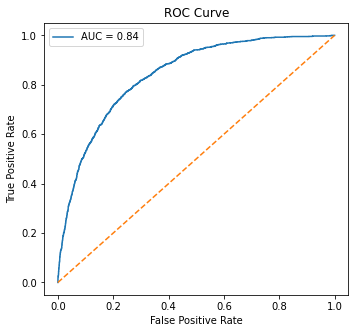

In [0]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# ROC
fpr, tpr, _ = roc_curve(pandas_df["label"], pandas_df["prob_class1"])
roc_auc = auc(fpr, tpr)

# Precision-Recall
precision, recall, _ = precision_recall_curve(pandas_df["label"], pandas_df["prob_class1"])

# Plot
plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()




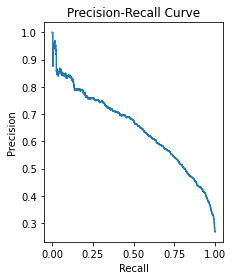

In [0]:
# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.tight_layout()
plt.show()

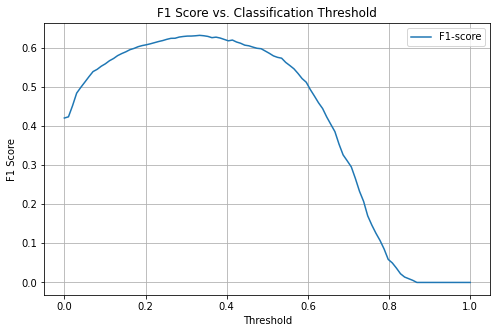

In [0]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Get true labels and predicted probabilities for the positive class
y_true = preds_pd['label']
y_scores = preds_pd['probability_array'].apply(lambda x: x[1])  # Class 1 probabilities

# Generate a range of thresholds between 0 and 1
thresholds = np.linspace(0, 1, 100)
f1_scores = []

# Calculate F1-score for each threshold
for threshold in thresholds:
    y_pred = (y_scores >= threshold).astype(int)
    f1 = f1_score(y_true, y_pred)
    f1_scores.append(f1)

# Plot F1 vs Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Classification Threshold')
plt.grid(True)
plt.legend()
plt.show()


In [0]:
# Find the best threshold and its corresponding F1 score
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1 Score: {best_f1:.4f}")


Best Threshold: 0.33
Best F1 Score: 0.6311


In [0]:
from pyspark.sql.functions import col, when, count

# 1. Create TP, FP, TN, FN columns
eval_df = predictions.withColumn("TP", when((col("label") == 1.0) & (col("prediction") == 1.0), 1).otherwise(0)) \
                     .withColumn("TN", when((col("label") == 0.0) & (col("prediction") == 0.0), 1).otherwise(0)) \
                     .withColumn("FP", when((col("label") == 0.0) & (col("prediction") == 1.0), 1).otherwise(0)) \
                     .withColumn("FN", when((col("label") == 1.0) & (col("prediction") == 0.0), 1).otherwise(0))

# 2. Sum up TP, FP, TN, FN
agg_vals = eval_df.selectExpr("sum(TP) as TP", "sum(FP) as FP", "sum(TN) as TN", "sum(FN) as FN").collect()[0]
TP = agg_vals['TP']
FP = agg_vals['FP']
TN = agg_vals['TN']
FN = agg_vals['FN']

# 3. Compute metrics
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# 4. Print results
print(f"Confusion Matrix:")
print(f"TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1_score:.4f}")


Confusion Matrix:
TP: 1000, FP: 533, TN: 4630, FN: 869
Precision: 0.6523
Recall:    0.5350
F1 Score:  0.5879


It seems sticking with 0.5 threshold is the best call consodering better preciison values it carries.
Threshold| Precision | Recall | F1-Score
0.5 (default) | 0.7916 | 0.8006 | 0.7939


0.33 (custom) | 0.6523 | 0.5350 | 0.5879